In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions   
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [3]:
# De# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [4]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [5]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [6]:
# Divide up into cars and notcars

from random import shuffle

images = glob.glob('vehicles/GTI_Far/*.png')
cars = []
for image in images:
    cars.append(image)

images = glob.glob('vehicles/GTI_Left/*.png')
for image in images:
    cars.append(image)

images = glob.glob('vehicles/GTI_MiddleClose/*.png')
for image in images:
    cars.append(image)

images = glob.glob('vehicles/GTI_Right/*.png')
for image in images:
    cars.append(image)
    
images = glob.glob('vehicles/KITTI_extracted/*.png')
for image in images:
    cars.append(image)    



In [7]:
images = glob.glob('non-vehicles/Extras/*.png')
notcars = []
for image in images:
    notcars.append(image)

images = glob.glob('non-vehicles/GTI/*.png')
for image in images:
    notcars.append(image)

8968


In [8]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size_cars = len(cars)

sample_size_cars = len(cars)
cars = cars[0:sample_size_cars]
shuffle(cars)

sample_size_non_cars = len(notcars)
notcars = notcars[0:sample_size_non_cars]
shuffle(notcars)

8792
8792
8968


In [18]:
### TODO: Tweak these parameters and see how the results change.
image_test = mpimg.imread('test_images/test1.jpg')
img_shape = image_test.shape

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [int(img_shape[0] * 0.5), img_shape[0]] # Min and max in y to search in slide_window()LL"
y_start_stop = [int(img_shape[0] * 0.5), img_shape[0]]
xy_window_size = (64, 64)
xy_overlap_size = (0.6, 0.6)
print(y_start_stop)

[360, 720]


In [10]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [11]:
print(len(car_features))
print(len(notcar_features))

8792
8968


In [12]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
print(X_scaler)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print(len(X))

StandardScaler(copy=True, with_mean=True, with_std=True)
17760


In [13]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [14]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print(len(X_test))

3552


In [15]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
4.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


In [16]:
dist_pickle = {"svc":svc, "scaler":X_scaler, "orient":orient, "pix_per_cell": pix_per_cell, "cell_per_block":cell_per_block, "spatial_size":spatial_size,"hist_bins":hist_bins}

In [17]:
from sklearn.externals import joblib
joblib.dump(dist_pickle, 'filename.p') 

['filename.p']

In [7]:
from sklearn.externals import joblib
dist_pickle1 = joblib.load('filename.p')

D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
%matplotlib inline

svc = dist_pickle1["svc"]
X_scaler = dist_pickle1["scaler"]
orient = dist_pickle1["orient"]
pix_per_cell = dist_pickle1["pix_per_cell"]
cell_per_block = dist_pickle1["cell_per_block"]
spatial_size = dist_pickle1["spatial_size"]
hist_bins = dist_pickle1["hist_bins"]
color_space = 'YCrCb' 

In [20]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [22]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [23]:
def draw_labeled_bboxes(img, labels, im=None):
    # Iterate through all detected cars
    b_heat=[]
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        # Draw the box on the image
        if not img is None:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,200), 3)
        
        b_heat.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
        
    # Return the image
    if not im is None:
        return img,b_heat
    else:
        return b_heat

In [24]:
from scipy.ndimage.measurements import label
# Visualize the heatmap when displaying    
#heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
#labels = label(heatmap)
#draw_img = draw_labeled_bboxes(np.copy(image), labels)

#plt.imshow(draw_img)

In [25]:
nframes = 10
bbox_frames =[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0

In [26]:
def draw_image(img):
    global counter
    global bbox_frames
    
    counter+=1
    countFrame = counter % nframes
    ima=np.copy(img)
    img = img.astype(np.float32)/255
    img_shape = img.shape
    y_start_stop = [int(img_shape[0] * 0.5), img_shape[0]]
    
    hot_windows1=[]
    windows1=[]
    # Get list of windows to search at this stage.
    for xy_window_size in [ (64,64),(96,96)]:
        windows1 = slide_window(img, x_start_stop=[img_shape[1]*0.3, img_shape[1]], y_start_stop=y_start_stop, 
                                xy_window=xy_window_size, xy_overlap=xy_overlap_size)        

        # Return all the windows the classifier has predicted contain car(s) ('positive windows').
        hot_windows1 = search_windows(img, windows1, svc, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat) 
        
        
    # Add heat to each box in box list
    heat1 = np.zeros_like(img[:,:,0]).astype(np.float)
    heat1 = add_heat(heat1,hot_windows1)
    heatmap1 = np.clip(heat1, 0, 255)    
    
    # Find boxes from heatmap using label function
    #heatmap1 = apply_threshold(heat1, 8)
    labels1 = label(heatmap1)    
    
    label_box = draw_labeled_bboxes(np.copy(ima), labels1)    
    
    #Store the rectangles of the frame
    bbox_frames[countFrame] = hot_windows1
    
    #Sum rectangles of the nframes
    bbox2=[]
    for box in bbox_frames:
        if box!=0:
            for b in box:
                bbox2.append(b)    
    
    heat2 = np.zeros_like(img[:,:,0]).astype(np.float)
    heat2 = add_heat(heat2,bbox2)
    heatmap2 = np.clip(heat1, 0, 255)    
    
    # Find final boxes from heatmap using label function
    #heatmap2 = apply_threshold(heat2, 6)
    labels2 = label(heatmap2)    
    
    draw_img1, label_box = draw_labeled_bboxes(np.copy(ima), labels2,np.copy(ima))          
    
    return draw_img1

D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


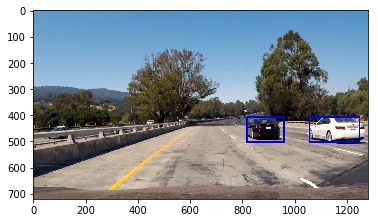

In [28]:
image = mpimg.imread('test_images/test1.jpg')
dr = draw_image(image)
plt.imshow(dr)
plt.imsave('output_images/test1.jpg', dr)

D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


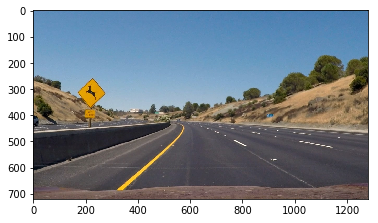

In [29]:
image = mpimg.imread('test_images/test2.jpg')
dr = draw_image(image)
plt.imshow(dr)
plt.imsave('output_images/test2.jpg', dr)

D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


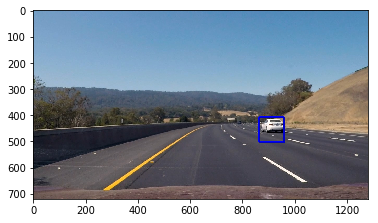

In [30]:
image = mpimg.imread('test_images/test3.jpg')
dr = draw_image(image)
plt.imshow(dr)
plt.imsave('output_images/test3.jpg', dr)

D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


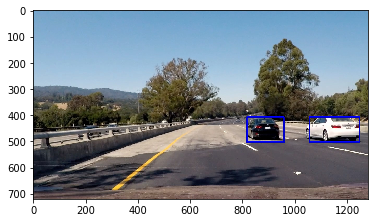

In [31]:
image = mpimg.imread('test_images/test4.jpg')
dr = draw_image(image)
plt.imshow(dr)
plt.imsave('output_images/test4.jpg', dr)

D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


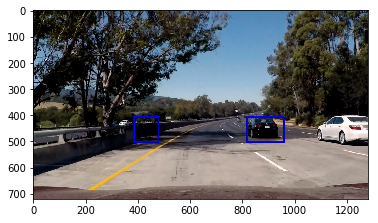

In [32]:
image = mpimg.imread('test_images/test5.jpg')
dr = draw_image(image)
plt.imshow(dr)
plt.imsave('output_images/test5.jpg', dr)

D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


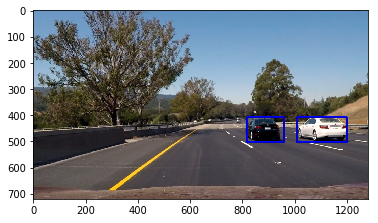

In [33]:
image = mpimg.imread('test_images/test6.jpg')
dr = draw_image(image)
plt.imshow(dr)
plt.imsave('output_images/test6.jpg', dr)

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [2]:
def process(image__):
    return draw_image(image__)
output = 'p5.mp4'
clip1 = VideoFileClip("./project_video.mp4")
output_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)